In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import geopandas as gpd
import random
import unidecode
import os
from IPython.display import display, Markdown, Latex



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.dpi'] = 150

from datetime import date
# FECHA_ACTUAL = str(date.today().strftime('%d/%m/%Y'))

import warnings
warnings.filterwarnings("ignore")

In [ ]:
PREDICT_PATH = os.environ['PREDICT_PATH']
# display(Markdown(f'# PREDICT_PATH: {PREDICT_PATH}'))

JOIN_PATH = os.environ['JOIN_PATH']
# display(Markdown(f'# PREDICT_PATH: {JOIN_PATH}'))

In [3]:
df_proba = pd.read_csv(PREDICT_PATH, low_memory=False).set_index('Alumno_ID')
df_proba.head(5)

df_x = pd.read_csv(JOIN_PATH, low_memory=False).set_index('Alumno_ID')
df = df_x.join(df_proba,  lsuffix='_left')
df['semaforo'] = df[df.filter(regex='semaforo').columns]

# df.head()

In [4]:
display(Markdown(f'# Reporte ITE'))
display(Markdown(f"### El siguiente reporte fue realizado automáticamente en base a los resultados del modelo para el año { df_proba['año'].iloc[0] } utilizando los archivos que se encuentran en la carpeta `{JOIN_PATH.split('/')[-2]}`"))

display(Markdown(f"### Los umbrales utilizados fueron `{df_proba.columns[-1].split('_')[-2]}` y `{df_proba.columns[-1].split('_')[-1]}`"))

# Reporte ITE

### El siguiente reporte fue realizado automáticamente en base a los resultados del modelo para el año 2022 utilizando los archivos que se encuentran en la carpeta `test2022`

### Los umbrales utilizados fueron `0.2` y `0.8`

In [5]:
display(Markdown('## Distribución de ITE'))
display(Markdown('### Distribución de la probabilidad de abandono'))

## Distribución de ITE

### Distribución de la probabilidad de abandono

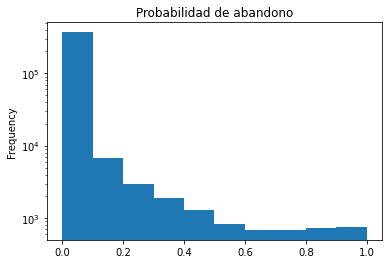

In [6]:
df['abandono'].plot(kind='hist');
plt.title('Probabilidad de abandono')
plt.yscale('log')

plt.show()

In [7]:
display(Markdown('## Variables categoricas'))

## Variables categoricas

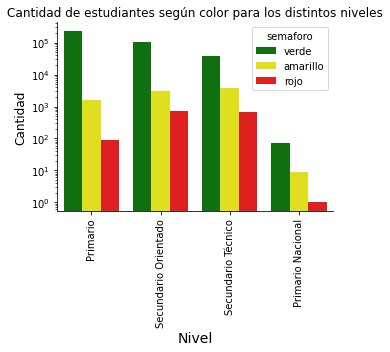

In [8]:

def graficar_categoricas_semaforo(df, variables_categoricas, sin_verde=False):
    """Grafica variables categoricas en funcion del semaforo

    Args:
        df (): _description_
        variables_categoricas (_type_): _description_
        sin_verde (bool, optional): _description_. Defaults to False.
    """

    colores = ['green','yellow', 'red']
    for variable in variables_categoricas:
        grafico = sns.catplot(x=variable, data=df, kind="count", hue='semaforo', hue_order=["verde","amarillo", "rojo"], palette=(colores), legend_out=False)
        plt.title(f'Cantidad de estudiantes según color para los distintos niveles');

        # Para rotar las etiquetas 
        locs, labels = plt.xticks();
        grafico.set_ylabels('Cantidad', fontsize=12)
        grafico.set_xlabels(fontsize=14)
        plt.setp(labels, rotation=90);
        plt.tight_layout()
        plt.yscale('log')
        # plt.savefig(f'{variable}.png')
        plt.show()


variables_categoricas = ['Nivel']
graficar_categoricas_semaforo(df, variables_categoricas)

In [10]:
# # sns.catplot(x=variable, data=df, kind="count", hue='semaforo', palette=(colores), legend_out=False)

# df['nivel_normalizado'] = (df['Nivel'].value_counts(normalize=True, sort=False)*100)

# colores = ['green','yellow', 'red']

# sns.catplot(x='nivel_normalizado', data=df, kind="count", hue='semaforo', palette=(colores), legend_out=False)
# plt.show()

In [11]:

for_map = {
    "GUAYMALLEN": "GUAYMALLÉN",
    "MAIPU": "MAIPÚ",
    "SAN MARTIN": "SAN MARTÍN",
    "LUJAN DE CUYO": "LUJÁN DE CUYO",
    "TUNUYAN": "TUNUYÁN",
    "GENERAL ALVEAR": "GRAL. ALVEAR"
}

In [13]:
# PATH_JSON = './departamentos-mendoza.json'
PATH_JSON = './visualization/departamentos-mendoza.json'
df_mendoza = gpd.read_file(PATH_JSON)   
df_mendoza = df_mendoza.set_index('departamento')
df_mendoza = df_mendoza.rename(index=for_map)

# Obtengo los centroides de cada departamento y los grafico
df_mendoza["centroid"] = df_mendoza.centroid

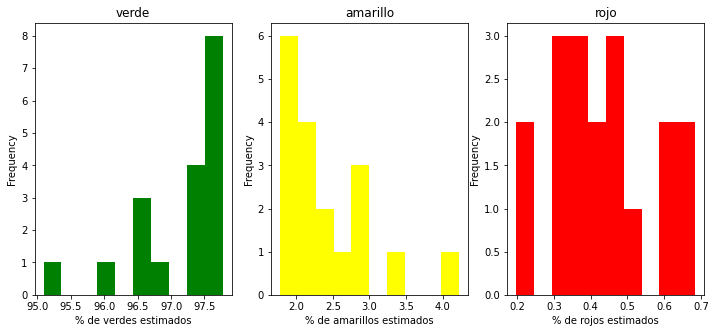

In [ ]:
# fig, axs = plt.subplots(1, 3)
# fig.set_figheight(5)
# fig.set_figwidth(12)

# (df_merged['verde']*100).plot(kind='hist', title='verde', ax=axs[0], color = "green").set_xlabel("% de verdes estimados");
# (df_merged['amarillo']*100).plot(kind='hist', title='amarillo', ax=axs[1], color = "yellow").set_xlabel("% de amarillos estimados");
# (df_merged['rojo']*100).plot(kind='hist', title='rojo', ax=axs[2], color = "red").set_xlabel("% de rojos estimados");



# plt.show()

In [ ]:
df_abandono = (
    df
    .set_index("departamento alumno")
    .groupby("departamento alumno")["semaforo"]
    .value_counts(normalize=True)
    .unstack()
)

df_merged = df_mendoza.join(df_abandono)


df_merged['verde_porcentaje'] = (df_merged['verde']*100)
df_merged['amarillo_porcentaje'] = (df_merged['amarillo']*100)
df_merged['rojo_porcentaje'] = (df_merged['rojo']*100)

In [16]:
display(Markdown('## Nivel de riesgo georreferenciado por departamento'))

## Nivel de riesgo georreferenciado por departamento

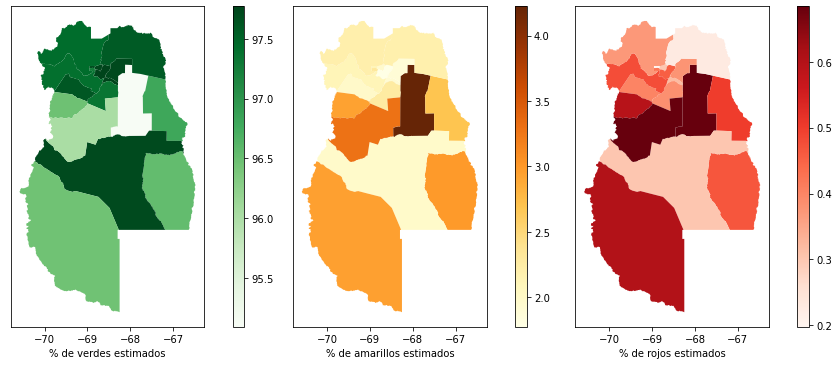

In [17]:

fig, axs = plt.subplots(1, 3)
x_axis = axs[0].axes.get_yaxis().set_visible(False)
x_axis = axs[1].axes.get_yaxis().set_visible(False)
x_axis = axs[2].axes.get_yaxis().set_visible(False)
# x_axis.set_visible(False)
fig.set_figheight(12)
fig.set_figwidth(12)

# verde
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
ax_verde = df_merged.plot(column='verde_porcentaje', cmap='Greens',legend=True, ax=axs[0] ,cax=cax).set_xlabel("% de verdes estimados");
# ax_verde.set_axis_off();

# amarillo
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
ax_amarillo = df_merged.plot(column='amarillo_porcentaje', cmap='YlOrBr',legend=True, ax=axs[1], cax=cax).set_xlabel("% de amarillos estimados");
# ax_amarillo.set_axis_off();

# rojo
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
ax_rojo = df_merged.plot(column='rojo_porcentaje', cmap='Reds',legend=True, ax=axs[2], cax=cax).set_xlabel("% de rojos estimados");
# ax_rojo.set_axis_off();
plt.tight_layout()

plt.show()
# plt.savefig('maps.png')